## LIBRERIAS

In [ ]:
import itertools
import os
import tarfile
import zipfile

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Mounted at /content/drive
TF version: 2.15.0
Hub version: 0.15.0
GPU is available


## IMPORTAR DATOS

In [ ]:
dataset = zipfile.ZipFile('/content/drive/MyDrive/dataset_tfm.zip','r')
dataset.extractall("/root/.keras/datasets/")


In [ ]:
data_dir = '/root/.keras/datasets/dataset_tfmm/flora_paramos'

## SELECCION DEL MODELO EFFICIENTNETV2 Y TAMAÑO DE IMAGENES

In [ ]:
model_name = "efficientnetv2-xl-21k"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"
pixels = 512

print(f"Modelo seleccionado: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Tamaño entrada {IMAGE_SIZE}")

BATCH_SIZE = 16

Modelo seleccionado: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Tamaño entrada (512, 512)


## DATOS DE ENTRENAMIENTO, VALIDACION Y PRUEBAS

In [ ]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.30,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.skip((2*val_batches) // 3)
val_ds = val_ds.take((2*val_batches) // 3)

valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(test_size)
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 10340 files belonging to 2 classes.
Using 7238 files for training.
Found 10340 files belonging to 2 classes.
Using 3102 files for validation.


## VISUALIZACION DE DATOS

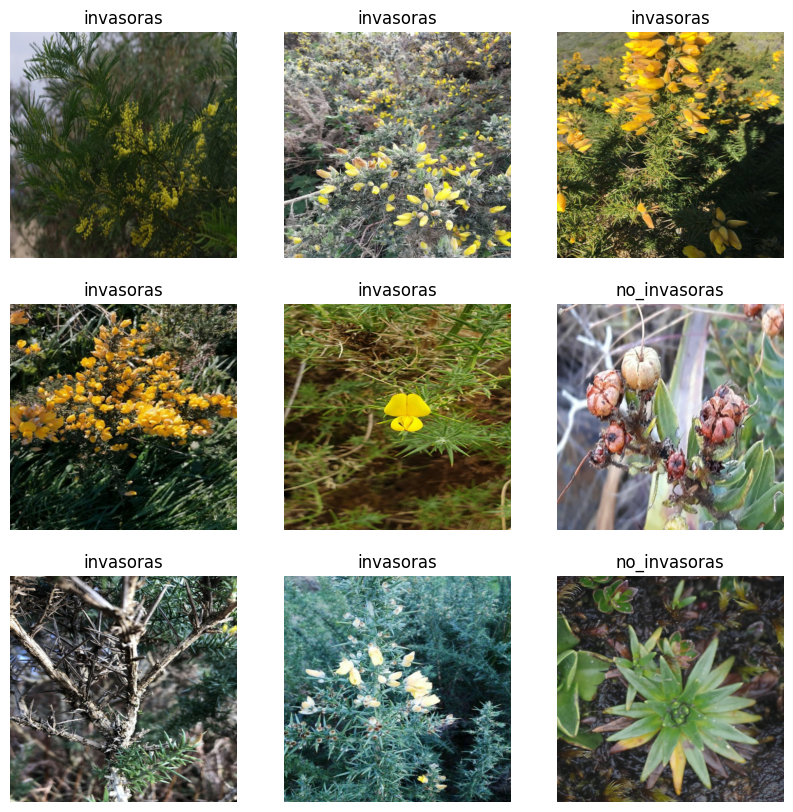

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## CONSTRUCCION DEL MODELO

In [ ]:
do_fine_tuning = False

In [ ]:
print("Construccion del modelo con", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Construccion del modelo con https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 207618394 (792.00 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 207615832 (791.99 MB)
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

## ENTRENAMIENTO DEL MODELO

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
452/452 [==============================] - 273s 531ms/step - loss: 0.4454 - accuracy: 0.9486 - val_loss: 0.3986 - val_accuracy: 0.9821
Epoch 2/5
452/452 [==============================] - 237s 522ms/step - loss: 0.3993 - accuracy: 0.9582 - val_loss: 0.4914 - val_accuracy: 0.9540
Epoch 3/5
452/452 [==============================] - 236s 521ms/step - loss: 0.3943 - accuracy: 0.9586 - val_loss: 0.4829 - val_accuracy: 0.9075
Epoch 4/5
452/452 [==============================] - 236s 522ms/step - loss: 0.3984 - accuracy: 0.9615 - val_loss: 0.3688 - val_accuracy: 0.9457
Epoch 5/5
452/452 [==============================] - 236s 522ms/step - loss: 0.4153 - accuracy: 0.9556 - val_loss: 0.3864 - val_accuracy: 0.9569


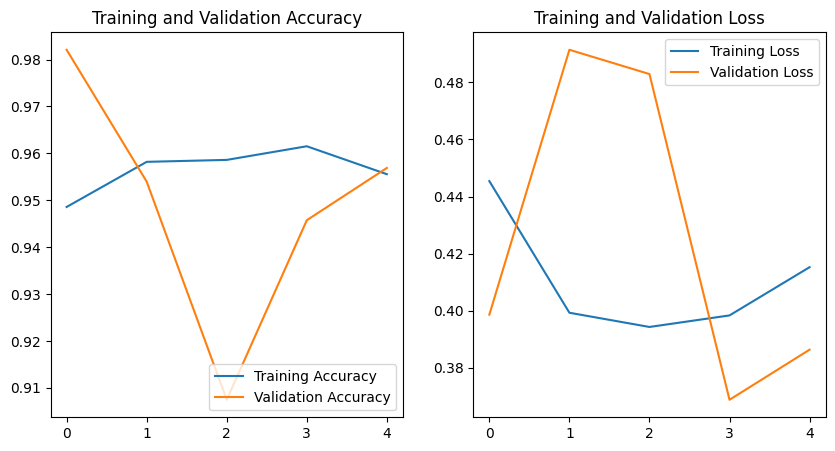

In [ ]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(5)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## VALIDACION DEL MODELO CON DATOS DE PRUEBA

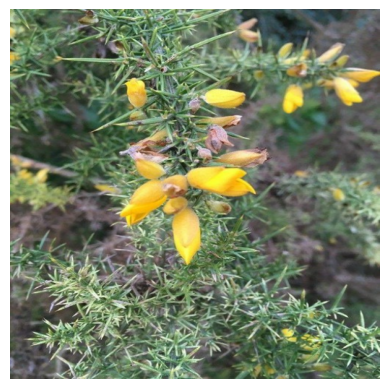

1/1 [==============================] - 0s 55ms/step
True label: invasoras
Predicted label: invasoras


In [ ]:
x, y = next(iter(test_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
#se obtienen las clases de los datos de prueba
true_test = np.argmax(y, axis=1)
print(true_test)

[0 0 0 ... 0 0 0]


In [ ]:
#se predicen las imagenes de prueba
test_pred= model.predict(x)

33/33 [==============================] - 29s 786ms/step


In [ ]:
#se obtienen las clases para las prediccciones de los datos de prueba
y_pred_classes = np.argmax(test_pred, axis=1)
y_pred_classes

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
#se hace el reporte de clasificacion
nn_report = classification_report(true_test, y_pred_classes, target_names=class_names)
print(nn_report)

              precision    recall  f1-score   support

   invasoras       1.00      0.94      0.97       826
no_invasoras       0.81      1.00      0.89       208

    accuracy                           0.95      1034
   macro avg       0.90      0.97      0.93      1034
weighted avg       0.96      0.95      0.95      1034



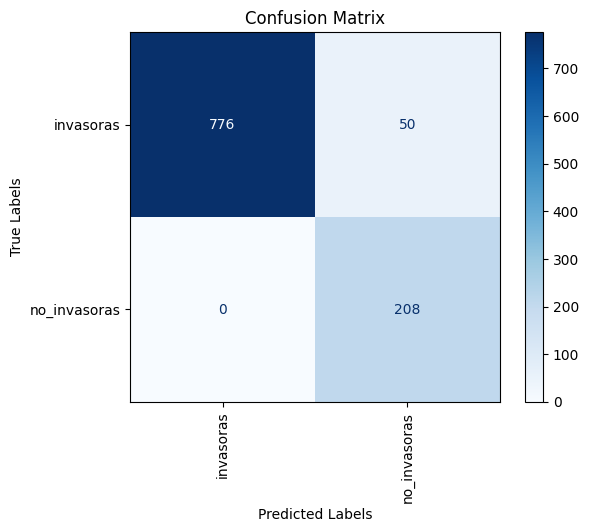

In [ ]:
#se calcula la matriz de confusion
cmRN = confusion_matrix(true_test, y_pred_classes)

# Crear el objeto ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cmRN, display_labels=class_names)

# Configurar y mostrar la matriz de confusión
cm_display.plot(cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()